<a href="https://colab.research.google.com/github/rastringer/blog_notebooks/blob/main/ai_safety.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Safety

AI Safety is a growing field of research to understand how neural networks work at the level of neurons or nodes, why they make their predictions, what can go wrong when they act in unintended or harmful ways, and how we can program guardrails to ensure they stay on track.

The first, key part of any AI safety approach is to be able to observe the inner workings of a neural net. There are two key angles to doing so; observing the weights and activations.

Weights concern the numerical values a model learns to adjust based on its inputs; activations are the values generated by each node in a forward pass, representing the level of 'activation', or strength, of a particular feature (the square footage of houses; the lines of cat's ears; the pitch of a birdsong).

### Set up the convolutional neural net

Here's our simple convolutional neural network in PyTorch which we will use for some investigations on the MNIST dataset of hand-drawn numbers, 0-9. It consists of:
* Two convolutional layers (`conv1` and `conv2`)
* Each conv layer is followed by rectified linear unit (ReLU) activation functions `relu1` and `relu2`
* Max pooling layers follow the activations to extract and downsample features from the input images
* Two fully connected layers `fc1` and `fc2` with another activation function `relu3`, the final of which outputs a 10-dimensional vector indicating the prediction for classification tasks.


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # Activation
        self.relu1 = nn.ReLU()
        # Max pooling
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Second convolutional layer etc
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    # Forward pass
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Set up for GPU / CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel()
model = model.to(device)

In [7]:
from torchsummary import summary

summary(model, (1, 28, 28))  # Assuming input image size is (1, 28, 28)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 1.61
Estimated Total Size (MB): 2.26
-------------------------------------------

In [10]:
! pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=3a7efd959c14819b34c17ffdeb106cea2e06c648d6bc181de453747b0e5bc783
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [12]:
from torchviz import make_dot

# Dummy input with the same size as the actual input data
dummy_input = torch.randn(1, 1, 28, 28).cuda()

# Generate a visualization of the model
graph = make_dot(model(dummy_input), params=dict(model.named_parameters()))
graph.render("CNNModel", format="png", cleanup=True)

'CNNModel.png'

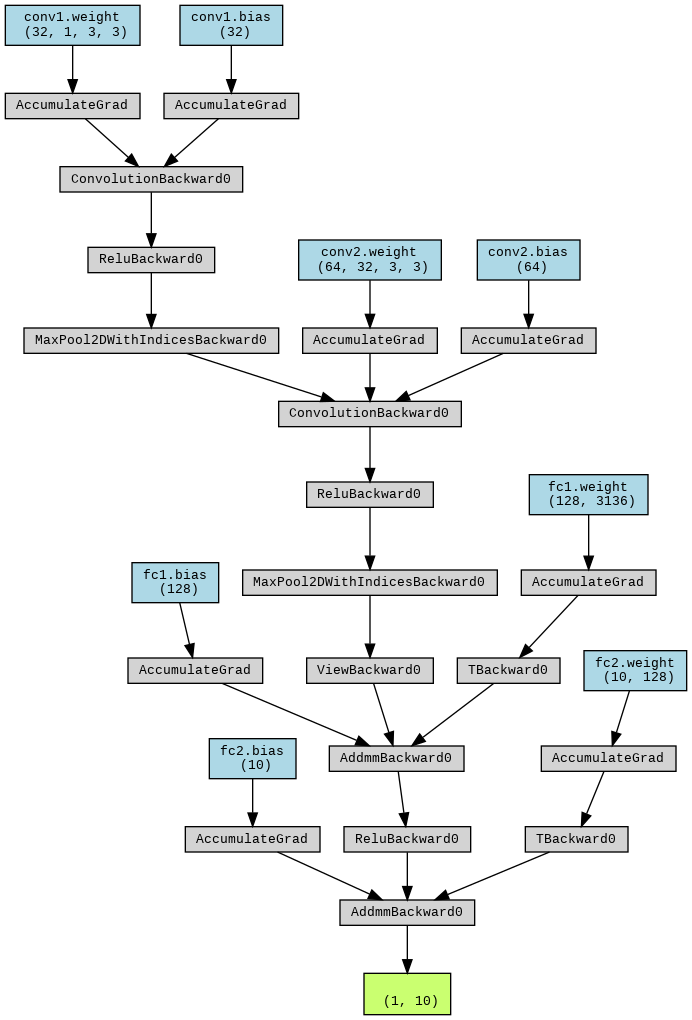

In [13]:
from IPython.display import Image, display

# Display the image in the notebook
image_path = "CNNModel.png"
display(Image(filename=image_path))


### Loading the dataset using torchvision

In [1]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Set up for GPU / CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
model = CNNModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

NameError: name 'transforms' is not defined

### Training loop

Here, we run through the entire dataset for `num_epochs` times and calculate the loss, gradients and weight updates.

In [ ]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU if available
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


### Displaying the activations

The activations show us the importance the model is assigning to different features, which in this case means darker and lighter parts of the image, or curves of drawn numerals.

## Hooks

Hooks are an interesting technique to employ callbacks to capture activations from the training and query what they have been up to.

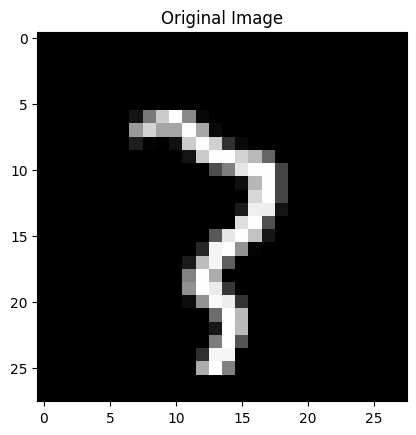

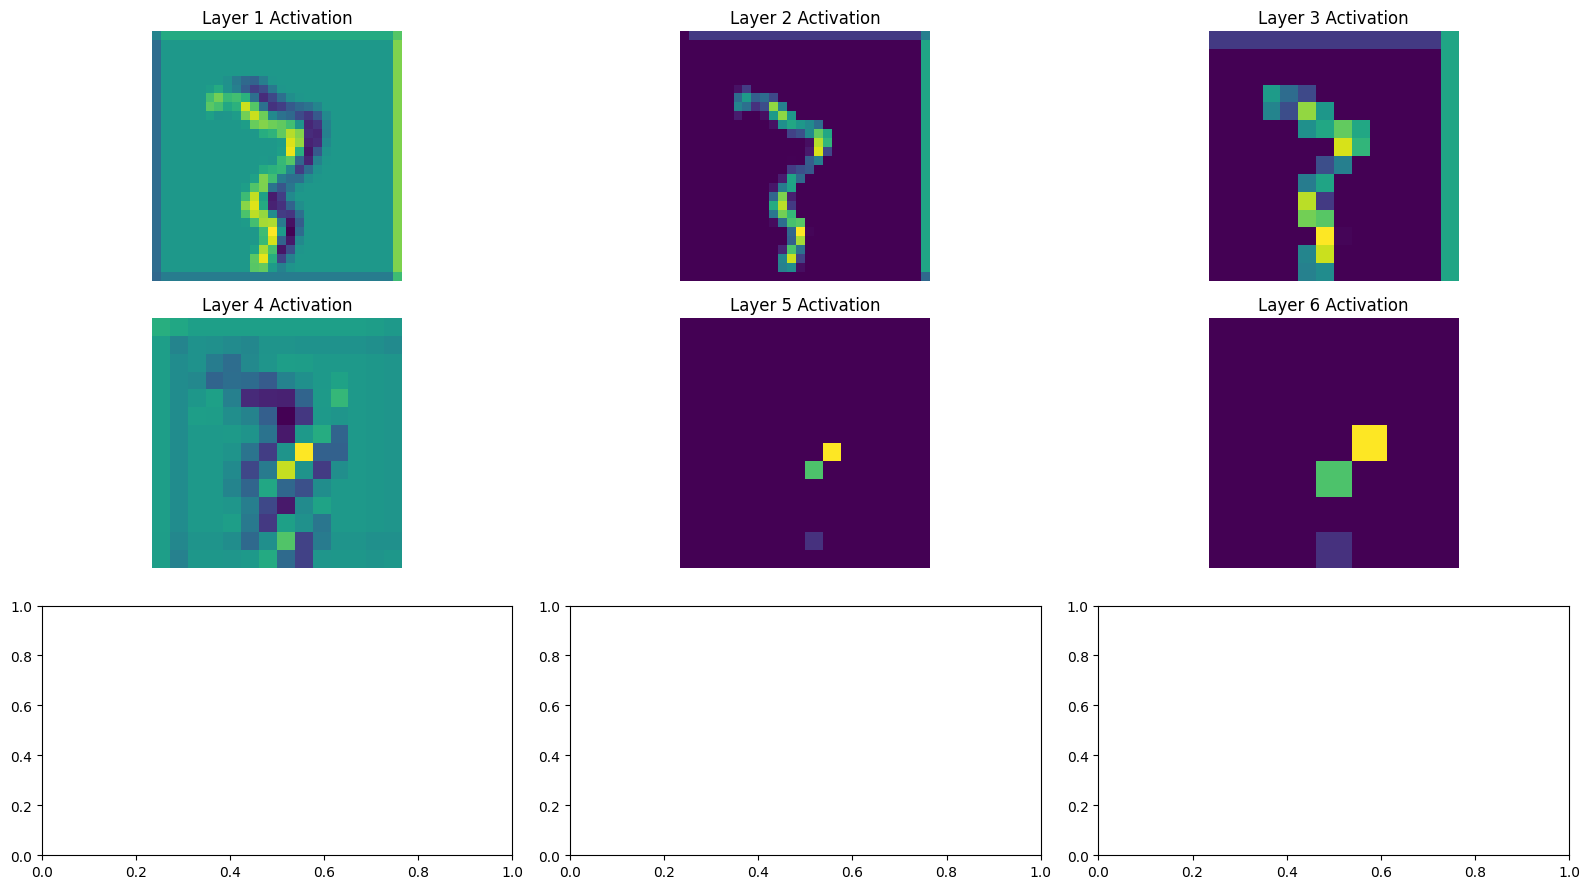

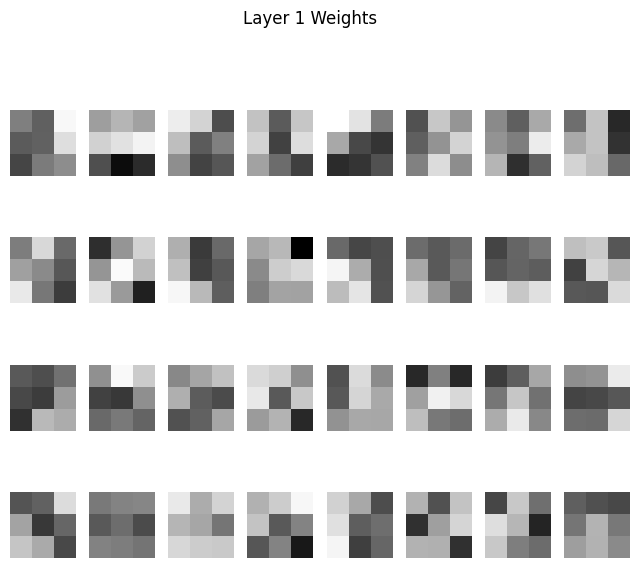

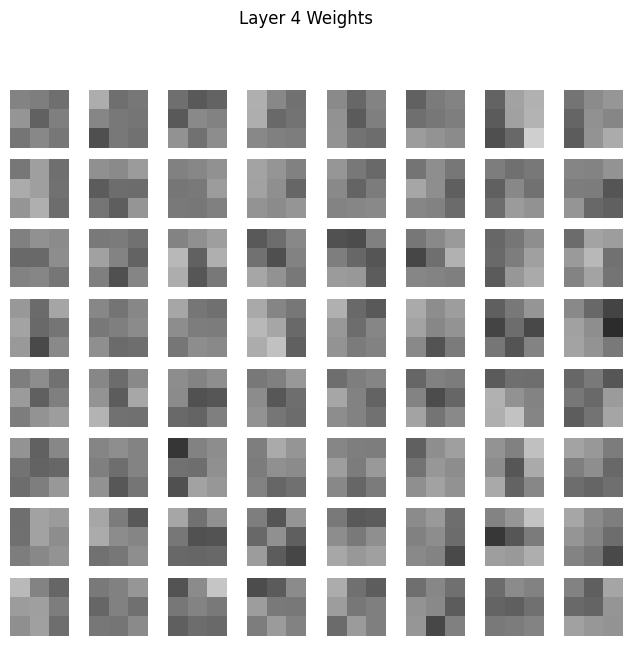

In [ ]:
# Visualization of activations
def plot_activations(model, input_tensor):
    activations = []

    # Register hooks to capture activations
    def hook_fn(module, input, output):
        activations.append(output)

    hooks = []
    for layer in model.children():
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)

    # Forward pass to capture activations
    with torch.no_grad():
        model(input_tensor)

    # Determine the number of rows and columns for the plot
    num_layers = len(activations)
    num_columns = min(3, num_layers)  # Display up to 3 activations per row
    num_rows = (num_layers + num_columns - 1) // num_columns

    # Plot the activations in a grid
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 3 * num_rows))

    for i, (activation, ax) in enumerate(zip(activations, axes.flatten())):
        if len(activation.size()) == 4:  # Check if it's a 4D tensor (activation map)
            ax.imshow(activation[0, 0].cpu().numpy(), cmap='viridis')
            ax.set_title(f'Layer {i+1} Activation')
            ax.axis('off')

    # Remove empty subplots
    for j in range(num_layers, num_rows * num_columns):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

    # Remove hooks
    for hook in hooks:
        hook.remove()



In [ ]:
# Choose a random image from the dataset for visualization
sample_image, _ = train_dataset[np.random.randint(len(train_dataset))]
sample_image = sample_image.unsqueeze(0)  # Add batch dimension
sample_image = sample_image.to(device)

# Display the original image
plt.imshow(sample_image[0, 0].cpu().numpy(), cmap='gray')
plt.title('Original Image')
plt.show()

# Display activations
plot_activations(model, sample_image)

### Plotting the weights

In [ ]:
# Display weights
def plot_weights(model):
    conv_layers = [layer for layer in model.children() if isinstance(layer, nn.Conv2d)]
    for i, layer in enumerate(conv_layers):
        plt.figure(figsize=(8, 8))
        weights = layer.weight.data.cpu().numpy()  # Move weights to CPU for visualization
        min_val, max_val = np.min(weights), np.max(weights)
        num_filters = weights.shape[0]
        for j in range(num_filters):
            plt.subplot(num_filters//8 + 1, 8, j+1)
            plt.imshow(weights[j, 0], cmap='gray', vmin=min_val, vmax=max_val)
            plt.axis('off')
        plt.suptitle(f'Layer {i*3 + 1} Weights')  # Adjust layer index
        plt.show()

# Display weights of convolutional layers
plot_weights(model)